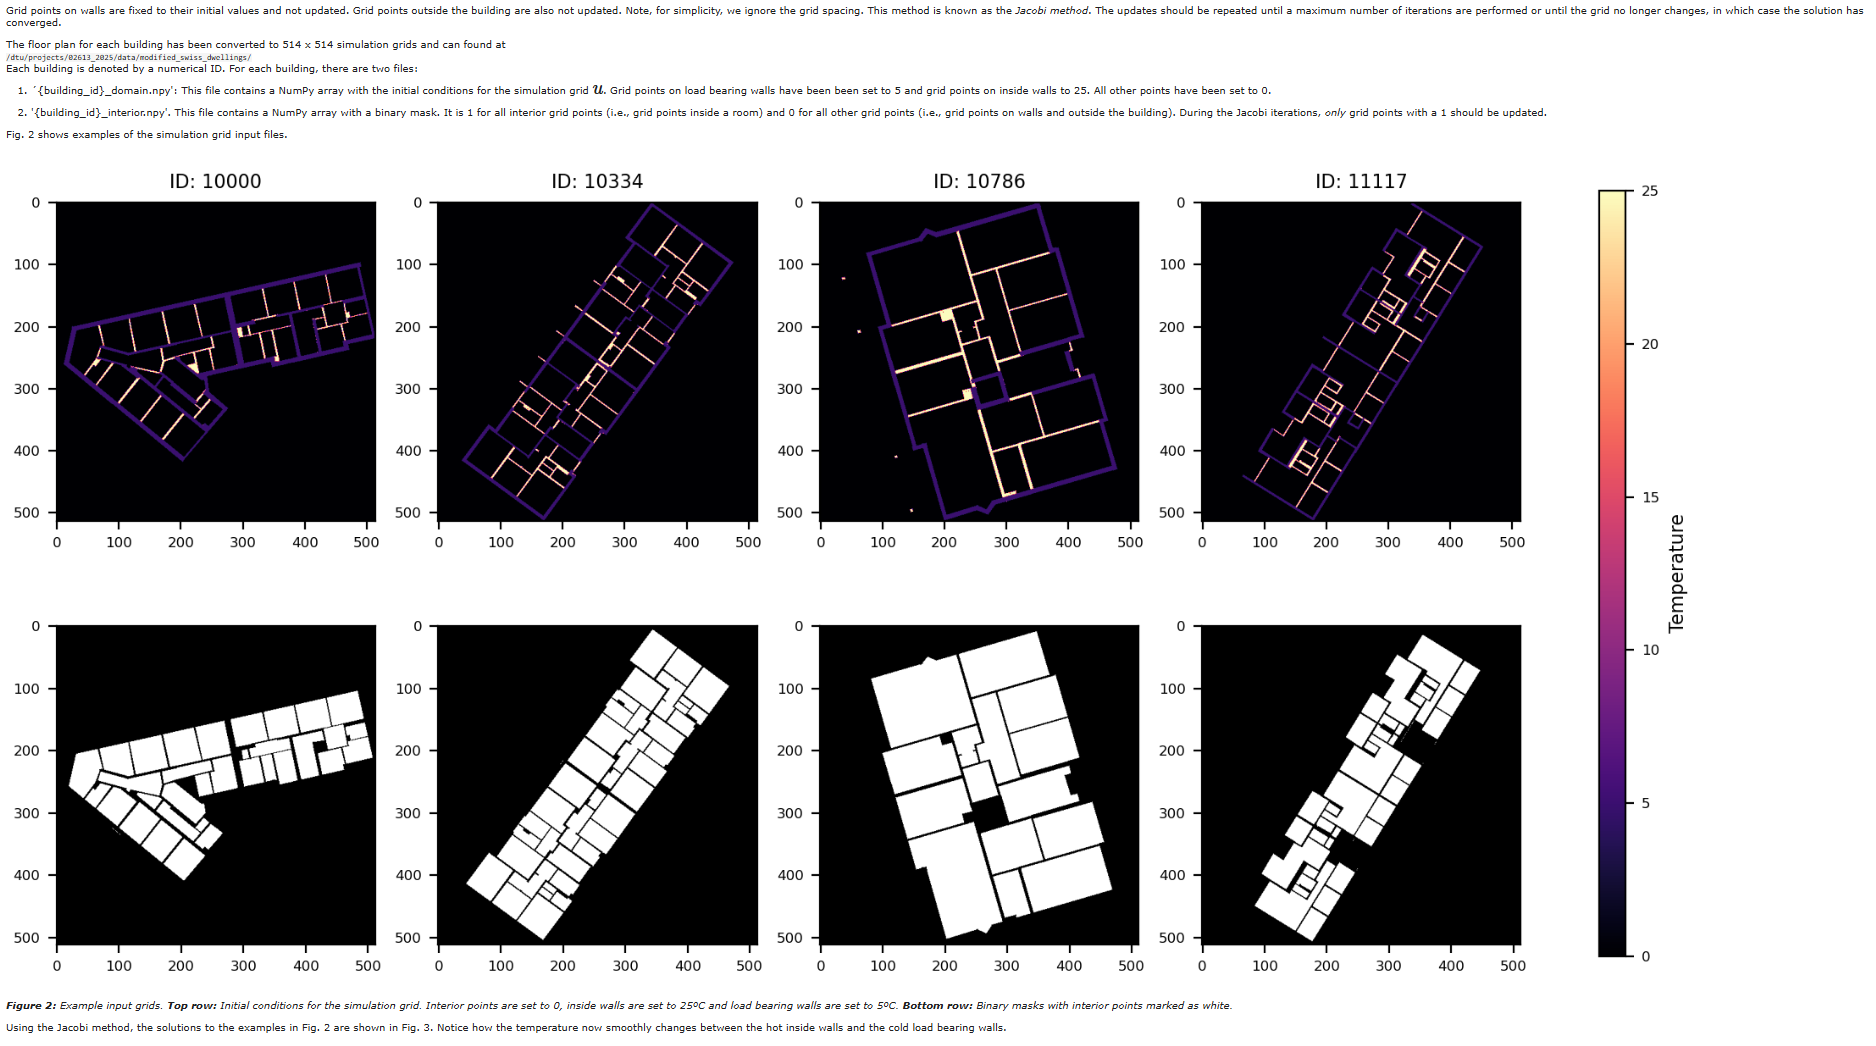

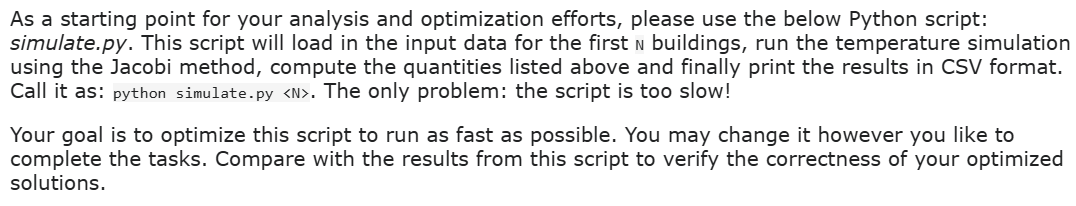

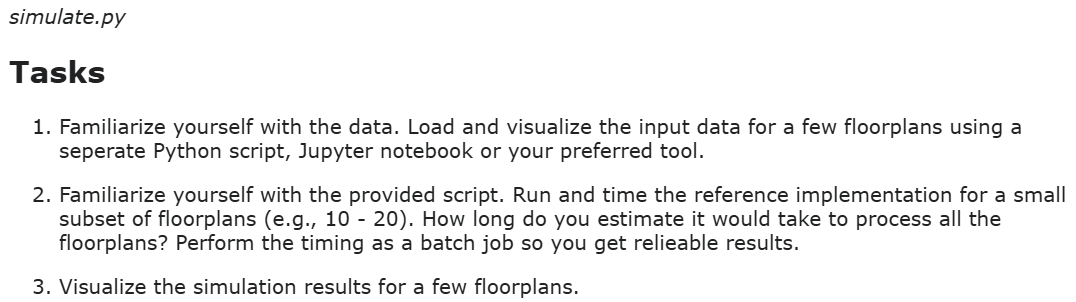

In [ ]:
from os.path import join
import sys

import numpy as np


def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }


if __name__ == '__main__':
    # Load data
    LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'
    with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
        building_ids = f.read().splitlines()

    if len(sys.argv) < 2:
        N = 1
    else:
        N = int(sys.argv[1])
    building_ids = building_ids[:N]

    # Load floor plans
    all_u0 = np.empty((N, 514, 514))
    all_interior_mask = np.empty((N, 512, 512), dtype='bool')
    for i, bid in enumerate(building_ids):
        u0, interior_mask = load_data(LOAD_DIR, bid)
        all_u0[i] = u0
        all_interior_mask[i] = interior_mask

    # Run jacobi iterations for each floor plan
    MAX_ITER = 20_000
    ABS_TOL = 1e-4

    all_u = np.empty_like(all_u0)
    for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
        u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
        all_u[i] = u

    # Print summary statistics in CSV format
    stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
    print('building_id, ' + ', '.join(stat_keys))  # CSV header
    for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
        stats = summary_stats(u, interior_mask)
        print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

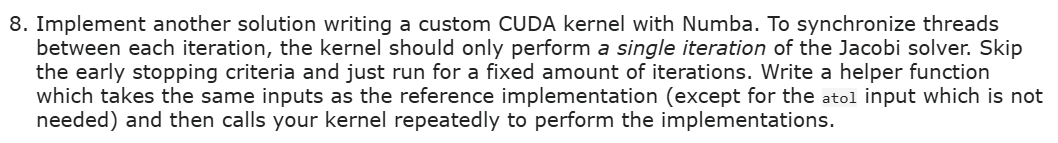

In [ ]:
# optimized 22 with some modifications of kernel func

from os.path import join
import sys
import numpy as np
import time
# sxm2sh
from numba import cuda

def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask

def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }

@cuda.jit
def jacobi_kernel(u, u_new, interior_mask):
    """
    CUDA kernel for a single Jacobi iteration.
    """
    #print('entered jacobi kernel')
    #u = np.copy(u)
    y,x = cuda.grid(2)

    if interior_mask[x - 1, y - 1]:  # Adjust for interior_mask being smaller from c
        #u = np.copy(u)
        u_new[x, y] = 0.25 * (u[x, y - 1]+ u[x, y + 1] +u[x - 1, y] + u[x + 1, y] )
        #u_new[x, y]= u_new[x,y][interior_mask]
    else:
        # If not in the interior, keep the value unchanged
        u_new[x, y] = u[x, y]

        # Compute average of left, right, up and down neighbors, see eq. (1)
        #u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        #u_new_interior = u_new[interior_mask]
        #u[1:-1, 1:-1][interior_mask] = u_new_interior
    
            
def jacobi_cuda(u, interior_mask, max_iter):
    """
    Helper function to perform Jacobi iterations using a CUDA kernel.
    """
    #print('entered jacobi cuda')
    # Allocate device memory
    u_device = cuda.to_device(u)
    #u_new_device = cuda.device_array_like(u)
    u_new_device = cuda.device_array_like(u_device)
    interior_mask_device = cuda.to_device(interior_mask)

    # Define thread and block dimensions
    # 1024=max value of threads per block
    # initial was (16,16)
    # threads_per_block = 256 in exercises with 
    #blocks_per_grid = (n + threads_per_block - 1) // threads_per_block #from c
    threads_per_block = (32, 32)
    #blocks_per_grid_x = (u.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
    #blocks_per_grid_y = (u.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]

    # from s
    blocks_per_grid_x = interior_mask.shape[0] // threads_per_block[0]
    blocks_per_grid_y = interior_mask.shape[1] // threads_per_block[1]

    #blocks_per_grid_x = int(np.ceil(interior_mask.shape[0] / threads_per_block[0]))
    #blocks_per_grid_y = int(np.ceil(interior_mask.shape[1] / threads_per_block[1]))

    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # warmup call]\
    #print('start warmup jacobi kernel')
    jacobi_kernel[blocks_per_grid, threads_per_block](u_device, u_new_device, interior_mask_device)
    #print('end warmup jacobi kernel')

    
    # Perform fixed number of iterations
    for i in range(max_iter):
        #print('entered jacobi cuda loop with jacobi_kernel in next line')
        #if (i*100/max_iter)%10==0: print(i*100//max_iter)
        jacobi_kernel[blocks_per_grid, threads_per_block](u_device, u_new_device, interior_mask_device)
        #cuda.synchronize() # Ensure all kernels are done
        u_device, u_new_device = u_new_device, u_device  # Swap buffers
    
    cuda.synchronize() # Ensure all kernels are done
    
    # Copy result back to host
    u_result = u_device.copy_to_host()

    return u_result



def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u



if __name__ == '__main__':
    t = time.time() 
    # Load data
    LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'
    with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
        building_ids = f.read().splitlines()

    print('building_ids shape: ',np.shape(building_ids))

    if len(sys.argv) < 2:
        N = 1
    else:
        N = int(sys.argv[1])
    building_ids = building_ids[:N]

    # Load floor plans
    all_u0 = np.empty((N, 514, 514))
    all_interior_mask = np.empty((N, 512, 512), dtype='bool')

    for i, bid in enumerate(building_ids):
        u0, interior_mask = load_data(LOAD_DIR, bid)
        all_u0[i] = u0
        all_interior_mask[i] = interior_mask

    # Run jacobi iterations for each floor plan
    MAX_ITER = 20000
    ABS_TOL = 1e-4

    all_u = np.empty_like(all_u0)


    for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
        #print('start with programs loop')
        u = jacobi_cuda(u0, interior_mask, MAX_ITER)
        all_u[i] = u

    # Print summary statistics in CSV format
    stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
    print('building_id, ' + ', '.join(stat_keys))  # CSV header
    for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
        stats = summary_stats(u, interior_mask)
        print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))
    t = time.time() - t
    print('Total time: ',t)

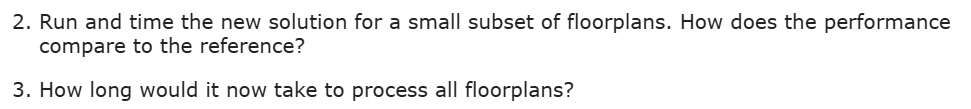

2. Running for 5 ids:
- Original code took: 48.625 seconds 
- CUDA code took: 6.933 seconds 

3. Running for 4571 while pushing a Job: 


In [ ]:
#!/bin/bash
### -- Job name --	
#BSUB -J zsleeperW		
### -- Queue name --		
#BSUB -q gpuv100	
### -- ask for number of cores (default: 1) -- 
#BSUB -n 4
### -- ask for number of nodes(default: 1) -- 
#BSUB -R "span[hosts=1]"
### -- Resources(mem) -- 
#BSUB -R "rusage[mem=5GB]"
### -- GPU model -- 
#BSUB -gpu "num=1:mode=exclusive_process"
### -- Resources(mem) -- 
#BSUB -R "select[gpu32gb]"
### -- Wall-clocktime -- 
#BSUB -W 15:00
### -- put email for notification -- 	
#BSUB -u geofr@dtu.dk
### -- send notification at start -- 
#BSUB -B 
### -- send notification at completion -- 
#BSUB -N 
### -- Output file (stdout) -- 
#BSUB -o sleeper_%J.out		
### -- Output file (stderr) -- 
#BSUB -e sleeper_%J.err		

source /dtu/projects/02613_2025/conda/conda_init.sh	
conda activate 02613	

### put before commands --  print information on the CPU type 
lscpu

numactl --interleave=all python3 sim23.py 4571

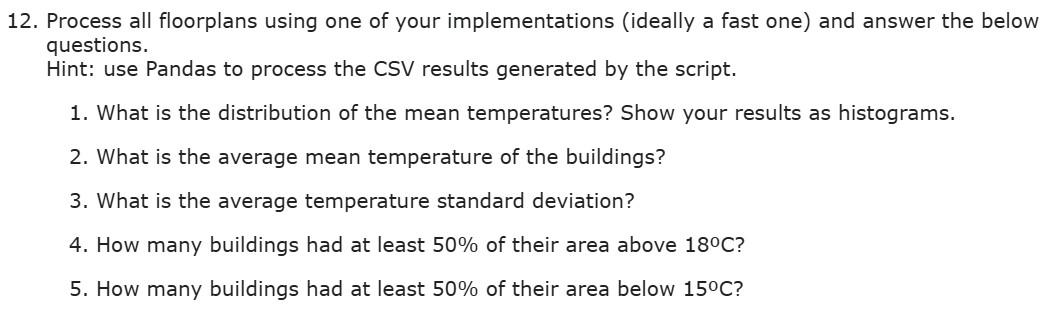

In [ ]:
# results are in allres.csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv('allres.csv')
print(df.head())
print(df.info())

headers=df.columns.tolist()
print(headers)

# distribution values
counts, bin_edges = np.histogram(df[' mean_temp'], bins=20)
print("Counts:", counts)
print("Bin edges:", bin_edges)

# Plot histogram for mean_temp
plt.hist(df[' mean_temp'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Mean Temperatures')
plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.savefig('/zhome/9b/1/213524/geofr/PHPC/ass/h1.png')
plt.close()

# What is the average mean temperature of the buildings
average_mean_temp = df[' mean_temp'].mean()
print("Average Mean Temperature:", average_mean_temp)

# What is the average temperature standard deviation
average_std_temp = df[' std_temp'].mean()
print("Average std Temperature:", average_std_temp)

#How many buildings had at least 50% of their area above 18ºC?
count_above_50 = df[df[' pct_above_18'] > 50.00].shape[0]
print("Number of buildings with at least 50% of their area above 18ºC:", count_above_50)

# How many buildings had at least 50% of their area below 15ºC?
count_below_50 = df[df[' pct_below_15'] > 50.00].shape[0]
print("Number of buildings had at least 50% of their area below 15ºC", count_below_50)


In [ ]:
   building_id   mean_temp   std_temp   pct_above_18   pct_below_15
0        10000   14.016445   6.368157      30.966330      55.475390
1        10009   11.010280   5.809287      16.697658      74.934667
2        10014   14.760094   7.028291      38.297266      52.748315
3        10019   14.752192   7.020491      38.191880      52.886542
4        10029   10.622508   6.312461      18.255632      74.513018
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4571 entries, 0 to 4570
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   building_id    4571 non-null   int64  
 1    mean_temp     4571 non-null   float64
 2    std_temp      4571 non-null   float64
 3    pct_above_18  4571 non-null   float64
 4    pct_below_15  4571 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 178.7 KB
None
['building_id', ' mean_temp', ' std_temp', ' pct_above_18', ' pct_below_15']
Counts: [  6  20  18  38  79 122 183 305 399 532 611 631 551 508 299 158  58  37
  11   5]
Bin edges: [ 6.82925616  7.56086843  8.2924807   9.02409297  9.75570524 10.48731752
 11.21892979 11.95054206 12.68215433 13.4137666  14.14537887 14.87699114
 15.60860341 16.34021568 17.07182795 17.80344022 18.53505249 19.26666476
 19.99827704 20.72988931 21.46150158]
Average Mean Temperature: 14.712974666034805
Average std Temperature: 6.798476227258994
Number of buildings with at least 50% of their area above 18ºC: 813
Number of buildings had at least 50% of their area below 15ºC 2460

![alt text](h1-1.png)